In [1]:
import sys
sys.path.append("/kaggle/input/dust3r-package")
sys.path.append("/kaggle/input/module-roma")
sys.path.append("/kaggle/input/einops/einops-master")
sys.path.append("/kaggle/input/trimesh-for-kaggle")

In [2]:
from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


In [3]:
src = "/kaggle/input/image-matching-challenge-2024"

... loading model from /kaggle/input/dust3r/pytorch/512_dpt/1/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='dpt', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 2 images
 - adding /kaggle/input/image-matching-challenge-2024/train/church/images/00001.png with resolution 1024x768 --> 512x384
 - adding /kaggle/input/image-matching-challenge-2024/train/church/images/00002.png with resolution 1024x768 --> 512x384
 (Found 2 images)
>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


 init edge (0*,1*) score=3.7025482654571533
 init loss = 0.003933314699679613
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 300/300 [00:38<00:00,  7.70it/s, lr=1.27413e-06 loss=0.0015534]


found 3353 matches


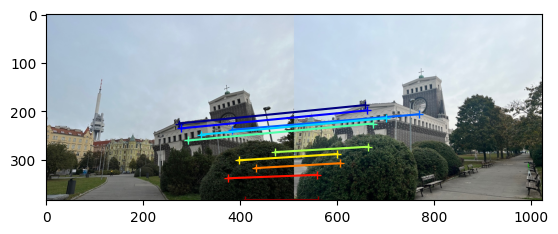

In [4]:
if __name__ == '__main__':
    device = 'cuda'
    batch_size = 1
    schedule = 'cosine'
    lr = 0.01
    niter = 300

    model_name = "naver/DUSt3R_ViTLarge_BaseDecoder_512_dpt"
    model_path = "/kaggle/input/dust3r/pytorch/512_dpt/1/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
    # you can put the path to a local checkpoint in model_name if needed
    model = AsymmetricCroCo3DStereo.from_pretrained(model_path).to(device)
    # load_images can take a list of images or a directory
    images = load_images([f'{src}/train/church/images/00001.png', f'{src}/train/church/images/00002.png'], size=512)
    pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
    output = inference(pairs, model, device, batch_size=batch_size)

    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    view2, pred2 = output['view2'], output['pred2']
    # here, view1, pred1, view2, pred2 are dicts of lists of len(2)
    #  -> because we symmetrize we have (im1, im2) and (im2, im1) pairs
    # in each view you have:
    # an integer image identifier: view1['idx'] and view2['idx']
    # the img: view1['img'] and view2['img']
    # the image shape: view1['true_shape'] and view2['true_shape']
    # an instance string output by the dataloader: view1['instance'] and view2['instance']
    # pred1 and pred2 contains the confidence values: pred1['conf'] and pred2['conf']
    # pred1 contains 3D points for view1['img'] in view1['img'] space: pred1['pts3d']
    # pred2 contains 3D points for view2['img'] in view1['img'] space: pred2['pts3d_in_other_view']

    # next we'll use the global_aligner to align the predictions
    # depending on your task, you may be fine with the raw output and not need it
    # with only two input images, you could use GlobalAlignerMode.PairViewer: it would just convert the output
    # if using GlobalAlignerMode.PairViewer, no need to run compute_global_alignment
    scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
    loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

    # retrieve useful values from scene:
    imgs = scene.imgs
    focals = scene.get_focals()
    poses = scene.get_im_poses()
    pts3d = scene.get_pts3d()
    confidence_masks = scene.get_masks()

    # visualize reconstruction
    scene.show()

    # find 2D-2D matches between the two images
    from dust3r.utils.geometry import find_reciprocal_matches, xy_grid
    pts2d_list, pts3d_list = [], []
    for i in range(2):
        conf_i = confidence_masks[i].cpu().numpy()
        pts2d_list.append(xy_grid(*imgs[i].shape[:2][::-1])[conf_i])  # imgs[i].shape[:2] = (H, W)
        pts3d_list.append(pts3d[i].detach().cpu().numpy()[conf_i])
    reciprocal_in_P2, nn2_in_P1, num_matches = find_reciprocal_matches(*pts3d_list)
    print(f'found {num_matches} matches')
    matches_im1 = pts2d_list[1][reciprocal_in_P2]
    matches_im0 = pts2d_list[0][nn2_in_P1][reciprocal_in_P2]

    # visualize a few matches
    import numpy as np
    from matplotlib import pyplot as pl
    n_viz = 10
    match_idx_to_viz = np.round(np.linspace(0, num_matches-1, n_viz)).astype(int)
    viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

    H0, W0, H1, W1 = *imgs[0].shape[:2], *imgs[1].shape[:2]
    img0 = np.pad(imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
    img1 = np.pad(imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
    img = np.concatenate((img0, img1), axis=1)
    pl.figure()
    pl.imshow(img)
    cmap = pl.get_cmap('jet')
    for i in range(n_viz):
        (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
        pl.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
    pl.show(block=True)